# Complexity Project

Aim of complexity is to understand a subclass non-equilibrium systems

Models studies include:
1. Oslo Model

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from itertools import zip_longest

### 1. Oslo Model
Grains are added to the left most pile, when the system has entered a staircase recurrent configuration, the grain the take L steps, before leaving the system. 

A recurrent configuration means that the system has reached a steady state, as it only occurs after all transient configurations have occured. Will occur with a frequency greater than one.

Previously, the Oslo model algorithm such that 
1. slopes would be driven, 
2. slopes would be relaxed changing z configuration. 
3. Check if any slope is larger than their threshold
    * If yes, repeat iteration across all slopes to relax
    * If no, generate new threshold and return to step 1)
    
Although simple, this implementation was extremely inefficient and would begin to face difficulty for system sizes of L > 50. Thus a more calculated approach was taken for the Oslo model, the algorithm goes as follows:

1. Drive slope
2. Relax slope i
3. Append to a list adjacent slopes of i (i.e. i+1, i-1), if z = z_+th + 1 (next_slopes)
    * If i = 1, or i = L, reduce only one neighbouring slope: i= 2 and i = L-1 respectively
4. If next_slopes are not empty, i.e. there are sites to relax, relax sites and repeat 3) if there are unrelaxed slopes. 
5. if next_slopes is empty, generate new random threshold and return to step 1) and drive system

- If in an edge case, where at site i has z_th of 1, and both site i-1 and site i+1 reduce, this would not reduce the slope sufficiently to be below the threshold. Thus append site i to next_slopes to relax in the following iteration

You wouldnt'expect the slope thresholds to be evenly split, because you are only driven from site i=1. Thus there are slopes closer to i =1 that are more regularly updated, in comparison to sites later down the slope. The fact that the later slopes remain in a certain threshold will skew the distribution

In [2]:
def plot_bar(z,title = "Oslo Model"):
    heights = np.cumsum(z[::-1])[::-1] #indexing to reverse list
    plt.figure(figsize= (8,5))
    plt.bar(np.arange(1,len(z)+1,1),heights)
    plt.title(title)
    plt.ylabel("Heights")
    plt.xlabel("sites")

114

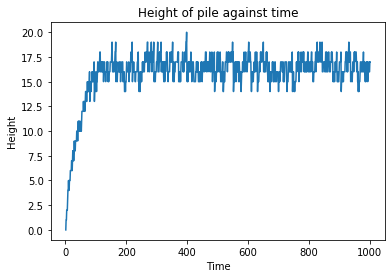

In [5]:
class Oslo:
    """
    Parameters
    L: Number of sites 
    plot: Plots heights if true
    p: probability
    N_recurrents: Number of recurrent runs after reaching steady state
    """
    
    def __init__(self,L, p =[1/2,1/2]):
        self.p = p
        self.L = L

    def run(self, plot=False, N_recurrents=None,title=None, check_slopes = False,N_runs = None):

        z = [0] * self.L

        # Allows for change in probabilities
        n = len(self.p)  # Number of thresholds, from probability
        z_ths = np.arange(1, n + 1, 1)  # Generates possible thresholds [1,2,...]

        # Initialisation
        z_th = [random.choice(z_ths) for x in range(self.L)]

        # Variables for testing
        end_value = 0
        avalanches = []
        z_avg_steady = []
        crossover = False  # To
        N_full_avalanche = 0  # Tracks full avalanches
        configurations = []  # Find number of unique configurations
        self.delta_heights = [0]
        self.cross_over_time = 0
        cross_over_time = 0

        if N_runs != None:
            N_count = N_runs
        elif N_recurrents != None:
            N_count = N_recurrents
        
        while end_value < N_count:

            # Drive
            z[0] += 1
            s = 0
            del_h = 1
            slopes_to_relax = [0]

            # Relaxation - Checks all slopes z relaxed, before driving again
            while len(slopes_to_relax) != 0:
                check_slopes = slopes_to_relax
                next_slopes = []
                for i in slopes_to_relax:
                    if z[i] > z_th[i]:
                        s += 1
                        if i == 0:
                            z[i] = z[i] - 2
                            z[i+1] = z[i+1] + 1
                            if z[i+1] == z_th[i+1] + 1:
                                next_slopes.append(i+1)
                            if crossover == False: cross_over_time += 1
                            del_h -= 1

                        elif i == len(z) - 1:  # index 0,...,L-1 ; len to L
                
                            z[len(z) - 1] = z[len(z) - 1] - 1
                            z[len(z) - 2] = z[len(z) - 2] + 1
                            crossover = True
                            if z[len(z) - 2] == z_th[len(z) - 2] + 1:
                                next_slopes.append(len(z) - 2)
#                             if steady == True: outflux += 1
                            
                            if self.cross_over_time == 0: self.cross_over_time = cross_over_time

                        else:
                            z[i] = z[i] - 2
                            z[i + 1] = z[i + 1] + 1
                            z[i - 1] = z[i - 1] + 1

                            if z[i+1] == z_th[i+1] + 1:
                                next_slopes.append(i+1)
                            if z[i-1] == z_th[i-1] + 1:
                                next_slopes.append(i-1)
                            
                        z_th[i] = random.choice(z_ths)
                        if z[i] > z_th[i]:
                            next_slopes.append(i)
                    else:
                        if crossover == False: cross_over_time += 1
                        pass

                if len(next_slopes) > 0:
                    # Finds unique next slopes.
                    slopes_to_relax = list(set(next_slopes))

                else:
                    slopes_to_relax = []

                # If avalance size is whole length of sites
    #             if s == L:
    # #                 print(s,z)
    #                 steady = True
    #                 N_full_avalanche += 1


                avalanches.append(s)
            # out of loop
            if N_runs != None:
                end_value +=1
            elif crossover == True:
                end_value += 1
                z_avg_steady.append(np.cumsum(z[::-1])[::-1][0])
#             else:
#                 raise ValueError("Not Counting!!")

                
            self.delta_heights.append(del_h)
                
            configurations.append(z[:])

            # Check
            if check_slopes == True:
                if any(x > max(z_ths) for x in z) == True:
                    print(z,z_th)
                    print(check_slopes)

                    raise ValueError("Not all sites relaxed")

        # Obtains cumulative sum of slopes, to represent heights
        final_heights = np.cumsum(z[::-1])[::-1]  # indexing to reverse list

        if plot == True:
            plot_bar(z)
        self.z = z

        return final_heights, z, np.mean(z_avg_steady), configurations
    
    def get_heights(self,plot = True):
#         print(len(self.z))
        heights = np.cumsum(self.delta_heights)
        time = np.arange(1,len(heights)+1,1)
        if plot == True:
            plt.xlabel("Time")
            plt.ylabel("Height")
            plt.title("Height of pile against time")
            plt.plot(time,heights,label = "L = {}".format(self.L))
        return time, heights
    
    def get_cross_over_times(self):
#         plt.axvline(self.cross_over_time)
        return self.cross_over_time

check = Oslo(10)
check.run(N_runs = 1000)
check.get_heights()
check.get_cross_over_times()

#TODO
1. Figure out how to stop the iterations
    I don't think you can us avalanche size because it is random in this
2. Devise own tests, to test on different values of p (e.g. p = 1), Ns Nr
3. Need to sort out steady state of Oslo, currently not entirely correct; 
4. Measure rate at which slopes changing??

### 1.1. Test 1,2: Expected Heights at site i =1
For p = 1/2, we expect the mean height for the first site to be around
* 26.5 for L = 16, and 
* 53.9 for L = 32

In [293]:
# Test 1, height_1 (L==16) = 26.5
Oslo_16 = Oslo(16)
avg_h1 = Oslo_16.run(N_recurrents=100000,check_slopes = True)[2]

print("Expected = {}, Model = {:.2f}, {:.2f}%".format(26.5,avg_h1,(avg_h1 - 26.5)/26.5 * 100))
4
# Test 2, height_1 (L==32) = 53.9
Oslo_32 = Oslo(32)
avg_h2 = Oslo_32.run(N_recurrents=100000)[2]
print("Expected = {}, Model = {:.2f}, {:.2f}%".format(53.9,avg_h2,(avg_h2 - 53.9)/53.9 * 100))

Expected = 26.5, Model = 26.52, 0.08%


KeyboardInterrupt: 

In [ ]:
# import time

# start = time.time()
# abc = Oslo(512)
# a,b,c,d = abc.run(check_slopes = False)

# end = time.time()

# print(end- start)
# print("DONE")

### 1.2 Test 3: Reduction to BTW Model (d=1)
For p=1, this should reduce back to the BTW model for d=1, where grains are only added at i=1. BTW does not account for possible spatial and temporal fluctuations, thus the steady state of the system should occur after a grain takes avalanche steps equal to the number of sites. 

This was shown from the test below

In [ ]:
# Test 3, p = 1, z_th = [1], Recurrent state should be L = 16
BTW = Oslo(16,p = [1])
BTW.run(plot= True,N_recurrents = 10,title = "Oslo to BTW (d=1)")
time,height = BTW.get_heights(plot = False)
print("Expected = {}, Model = {:.2f}".format(16,height[0]))

In [ ]:
# Test: N_s, N_r
# Test if p = 1/2, other Ls?
# Test for another p (p = 1/3?)
# average avalanche size / height (pg 279) --> <s> ~ L^2, but seems only apply when grains added randomly (not Oslo)
# <influx> = <outflux>? N grains, or energy, would be applicable to oslo cuz changes!! ~ but again, not Oslo?

### 1.3. Test 4: Recurrent Configurations

For the Oslo model, we expect N_R to be 5 for L = 2

In [ ]:
L = 1
N_S = 3**L

def N_R(L):
    phi = (1+np.sqrt(5))/2
    N_R = 1/np.sqrt(5)* (phi *(1+phi)**L + 1/(phi * (1+phi)**L))
    return N_R

Oslo_2 = Oslo(2,p = [0.5,0.5])
a,b,c,configurations = Oslo_2.run(plot= False,N_recurrents = 1000)

df = pd.DataFrame({"Configurations": configurations})
count_z =df["Configurations"].value_counts()
N_R_model = len(count_z[count_z >1])

print("Configurations")
print(count_z)
print("\n-- Additional configurations = [0,0],[2,0] or [0,1]")
print("\nNumber of recurrent configurations = {}, expected = {}".format(N_R_model,N_R(2)))

#### Random Funciton Efficiency Test

In [ ]:
import timeit

mysetup = """
import numpy as np
import random
L =100
prob = [0.5,0.5]
z_ths = [1,2]
"""

mycode = "np.random.choice(z_ths,p=prob)"
print("Numpy Random: ",timeit.timeit(setup = mysetup,stmt = mycode,number = 1000),"s")

mycode = "random.choice(z_ths)"
print("Inbuilt Random: ",timeit.timeit(setup = mysetup,stmt = mycode,number = 1000),"s")

## 2. Height of the Pile

This was implemented in the oslo model. Everytime a grain is added to the pile, the cound it increased by one. Everytime the final pile is reached, the count is reduced by negative one. Reduce by -1 as allows for multiple avalanches caused by one grain that could reduce the heights further.

Height of the pile $h(t;L)$is defined as 

$$h(t;L) = \sum^L_{i=1}z_i(t)$$

where $z_i(t)$ are the slopes. This essentially finds the sum of all the slopes, to find the height of the first pile.



### Task 2a 
Increasing the size of the system, would increase the number of recurrent configurations, as seen from the plot below. Recurrent configurations occur when the height of the pile begins to fluctuate around a certain value. 

Seems to follow a logarithmic distribution?

In [6]:
sizes = np.array([2,4,8,16,32,64,128,256])
sizes = np.array([2,4,8,16,32])

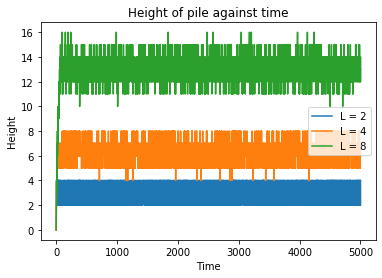

In [333]:
Oslo_models = [Oslo(L) for L in sizes]

times_sample = []
heights_sample = []

for Oslo_L in Oslo_models:
    Oslo_L.run(N_runs = 5000)
#     Oslo_L.run(N_recurrents = 1000)
    time,height = Oslo_L.get_heights()
    times_sample.append(time)
    heights_sample.append(height)
plt.legend()

### Task 2b
Cross-over time is the number of grains $\textbf{before}$ an added grain induces a grain to leave the system. It is seen as $t_c(L)$:
$$t_c(L) = \sum_{i=1}^{L} z_i  i$$

where $z_i$ are the local slopes in the system to which an added grain induces a flow out of the system for the first time.

Numerically add to t_c, until you enter the condition where it enters the last site. At this point 

[4, 5, 5, 4, 4, 4, 5, 5, 5, 4]
[16, 18, 14, 22, 18, 20, 20, 13, 16, 20]
[74, 74, 75, 66, 87, 77, 73, 53, 74, 76]
[]


Text(0, 0.5, 'Average cross-over time $<t_C>$')

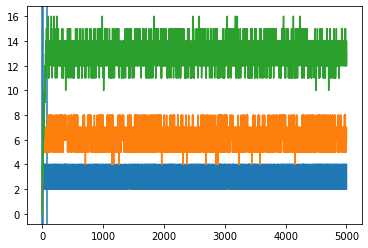

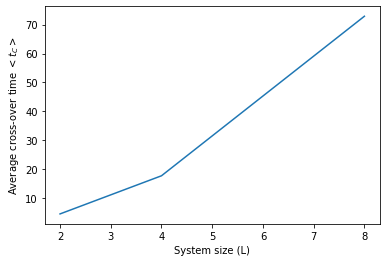

In [334]:
Oslo_models = [Oslo(L) for L in sizes]

crossover_avgs = []
for Oslo_L in Oslo_models:
    times = []
    for N in range(10):
        Oslo_L.run(N_recurrents = 1)
        times.append(Oslo_L.get_cross_over_times())
    print(times)
    avg_time = np.mean(times)
    crossover_avgs.append(avg_time)
    
[plt.axvline(crossover_avgs[i])for i in range(len(crossover_avgs))]
[plt.plot(times_sample[i],heights_sample[i])for i in range(len(times_sample))]
print(avgs)

plt.figure()
plt.plot(sizes,crossover_avgs)
plt.xlabel("System size (L)")
plt.ylabel("Average cross-over time $<t_C>$")

### Task 2c

a. Considering the height of the pile $h(t;L)$ as 

$$h(t;L) = \sum^L_{i=1}z_i(t)$$

where $L$ is the length/size of the system, $z_i$ is the slope at site $i$ and $t$ is time or number of grains added to system since the start. We can approximate all the slopes at all sites $i$ in the above equation as an average value. This reduces the equation to

$$\begin{equation}\begin{aligned} h(t;L) &= \sum^L_{i=1}<z> \\&= L \cdot <z>  \\ \Rightarrow h(t;L) &\propto L\end{aligned}\end{equation}$$


thus showing that $h(t;L) \propto L$ in a linear relationship.

b. Similarly for cross-over time, we have the following relation

$$t_c(L) = \sum^L_{i=1} z_i \cdot i$$

where $t_c(L)$ is the cross-over time. We can perform the same apprroximation of averaging all the slopes, to remove the slopes from the sum. Applying the arithmetic sum formula $S_n = \frac{N(N+1)}{2}$, we obtain


$$\begin{equation}\begin{aligned} t_c(L) &= <z> \cdot \sum^L_{i=1}  i \\ &=  <z> \cdot \frac{L(L+1)}{2} \approx <z> \cdot L^2 \\ \Rightarrow t_c(L) &\propto L^2 \end{aligned}\end{equation}$$

showing cross-over time approximated as a quadratic relation.


### Task 2d 

Smooth out the data using

$$\tilde h(t;L) = \frac{1}{M} \sum^M_{j=1} h^j(t;L) $$


In [7]:
Oslo_models = [Oslo(L) for L in sizes]

heights = []

avgs = []
for Oslo_L in Oslo_models:
    heights_full = []
    crossover_times = []
    for N in range(10):
        Oslo_L.run(N_runs=10000)
        time,heights_L = Oslo_L.get_heights(plot = False)
        heights_full.append(heights_L)

    # Adds lists of different lengths
    height = np.array([(n) for n in zip_longest(*heights_full)])
    height = [np.mean(list(filter(None, height[i]))) for i in range(len(height))]
    
    # First value is Nan, as mean of zero
    height.remove(height[0]) 

    heights.append(height)

### Finite Scaling Ansatz

The somewhat counterintuitive idea behind finite-size scaling is to use the dependence of measured properties on finite system size to extract critical exponents for the infinite system.

$$h(t;L)\propto t^{\tau}\mathcal{F}\Big(\frac{t}{t_C}\Big)$$

where define $x = \frac{t}{t_C}$

We can also describe cross-over time as 

$$ t_C \propto L^D $$

where $L$ is the length of the system and D is another critical exponent

From the situation in Task 2c), we expect $h \sim L$ and $t_C \sim L^2$, indicating $D \sim 2$. Combining these two situations, for times less than the cross over time, we expect the height to change as $h \sim \sqrt{t}$, hence the first exponent we will try is 0.5. This is reinforced as when looking at $h$ against $t$ on a non-log plot, the transient state looks to progress as a square root function. 

The point of this is to align vertically the cut off height of the pile; aligning the 'height' where the decay occurs. 'height' as align in height * time^tau

Then can apply the scaling ansatz, to find an expression that can describe an infinite system size, through its critical components, by extrapolating from a sample of finite size systems.

From analysing the log plots of heights, we can see that the scaling ansatz should follow

$$\mathcal{F} \propto \left\{\begin{array}{ll}
{\mathcal{F}(0)+\mathcal{F}^{\prime}(0) x+\frac{1}{2} \mathcal{F}^{\prime \prime}(0) x^{2}+\cdots} & {\text { if } t\ll t_C \text{ (or }x \ll 1)} \\
{\text{constant}} & {\text { if } t \gg t_C \text{ (or } x \gg 1)} 
\end{array}\right.$$

Must be like this so that it applies the decay at the correct time

and again since, we know t ~ L^2, we expect D ~ 2. 


NameError: name 'crossover_avgs' is not defined

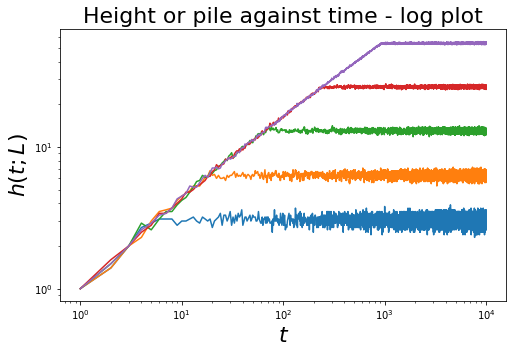

In [8]:
times = np.arange(1,len(height)+1,1)

plt.figure(figsize = (8,5))
plt.ylabel("$h(t;L)$",fontsize = 22)
plt.xlabel("$t$",fontsize = 22)
plt.title("Height or pile against time - log plot",fontsize = 22)
[plt.loglog(times,heights[i]) for i in range(len(heights))]
[plt.axvline(x = x) for x in crossover_avgs]

<Figure size 576x360 with 0 Axes>

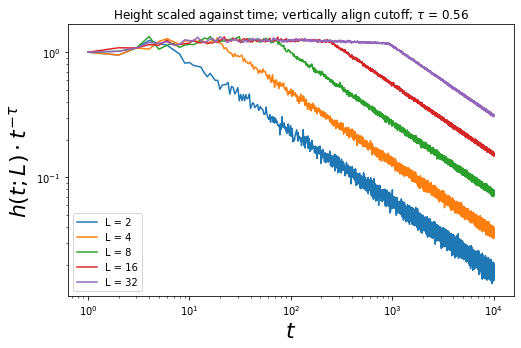

In [16]:
plt.figure(figsize = (8,5))

tau = -0.56#1 #inversed tau
times_tau = np.array(list(map(float,times))) ** (tau)
heights_t = [heights[i] * times_tau for i in range(len(heights))]

plt.figure(figsize = (8,5))
plt.title(r"Height scaled against time; vertically align cutoff; $\tau$ = {}".format(- tau))
plt.ylabel(r"$h(t;L) \cdot t^{- \tau}$",fontsize =22)
plt.xlabel("$t$",fontsize = 22)
[plt.loglog(times,heights_t[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
plt.legend()

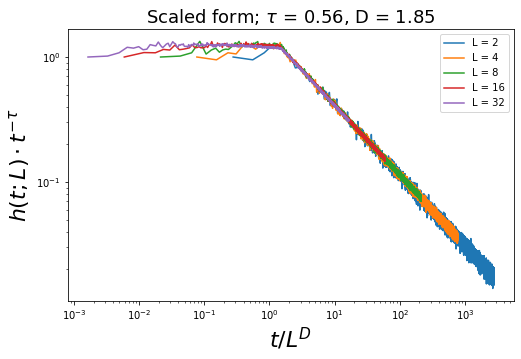

In [17]:
D = 1.85
# D = 2
plt.figure(figsize = (8,5))

plt.title(r"Scaled form; $\tau$ = {}, D = {}".format(- tau,D),fontsize = 18)
plt.xlabel("$t / L^D$",fontsize = 22)
plt.ylabel(r"$h(t;L) \cdot t^{- \tau}$",fontsize =22)
times_L = [times/ L**D for L in sizes]
[plt.loglog(times_L[i],heights_t[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
plt.legend()

<Figure size 576x360 with 0 Axes>

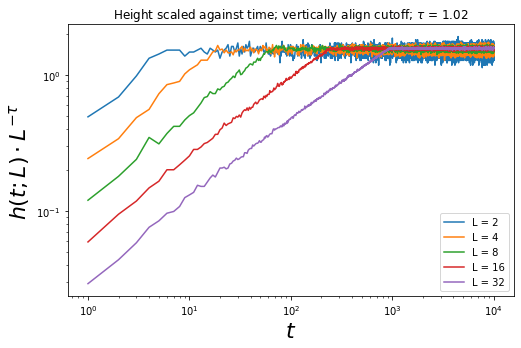

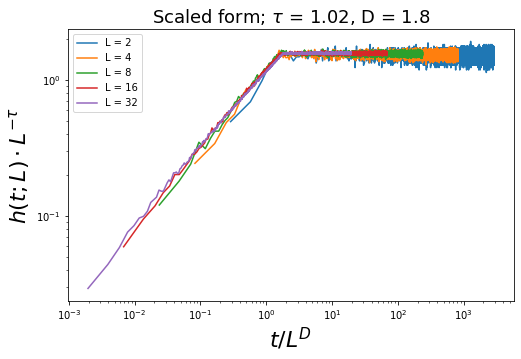

In [47]:
plt.figure(figsize = (8,5))

tau = 1.02 #
# times_tau = np.array(list(map(float,times))) ** (tau)
heights_t = [heights[i] / sizes[i]**tau for i in range(len(sizes))]

plt.figure(figsize = (8,5))
plt.title(r"Height scaled against time; vertically align cutoff; $\tau$ = {}".format(tau))
plt.ylabel(r"$h(t;L) \cdot L^{- \tau}$",fontsize =22)
plt.xlabel("$t$",fontsize = 22)
[plt.loglog(times,heights_t[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
plt.legend()

# D = 1.85
D = 1.8

plt.figure(figsize = (8,5))

plt.title(r"Scaled form; $\tau$ = {}, D = {}".format(tau,D),fontsize = 18)
plt.xlabel("$t / L^D$",fontsize = 22)
plt.ylabel(r"$h(t;L) \cdot L^{- \tau}$",fontsize =22)
times_L = [times/ L**D for L in sizes]
[plt.loglog(times_L[i],heights_t[i],label = "L = {}".format(sizes[i])) for i in range(len(heights))]
plt.legend()


# Questions 
2. A method to calculate i=1 for different values of p?